### 使用InceptionResNetV2模型在ImageNet数据集预训练的参数。
### 首先调用预处理函数，卷集层输出使用全局平均池化处理，最后保留模型输出的1536维特征

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from sklearn.utils import shuffle
import pandas as pd
from keras.preprocessing.image import *


np.random.seed(2018)

base_model = InceptionResNetV2(input_tensor=Lambda(inception_resnet_v2.preprocess_input)(Input((299,299,3))), 
                               weights='imagenet',include_top = False)
model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

gen1 = ImageDataGenerator()  #图片生成器ImageDataGenerator

train_generator = gen1.flow_from_directory("train2",(299,299),shuffle=False,batch_size=16)
test_generator = gen1.flow_from_directory("test2", (299,299), shuffle=False, batch_size=16,class_mode=None)

train = model.predict_generator(train_generator,steps = train_generator.samples/16)
test = model.predict_generator(test_generator,steps = test_generator.samples/16)



/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 以上base_model所有层未被训练，也不要要训练。以下将添加的层需要训练，调整权值。
### fine-tuning好的网络将预测测试集的结果，并将结果提交Kaggel

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 95us/step - loss: 0.1327 - acc: 0.9685 - val_loss: 0.0443 - val_acc: 0.9912
Epoch 2/10
20000/20000 [==============================] - 0s 24us/step - loss: 0.0377 - acc: 0.9919 - val_loss: 0.0294 - val_acc: 0.9926
Epoch 3/10
20000/20000 [==============================] - 0s 21us/step - loss: 0.0272 - acc: 0.9938 - val_loss: 0.0264 - val_acc: 0.9928
Epoch 4/10
20000/20000 [==============================] - 0s 22us/step - loss: 0.0246 - acc: 0.9941 - val_loss: 0.0240 - val_acc: 0.9934
Epoch 5/10
20000/20000 [==============================] - 0s 24us/step - loss: 0.0235 - acc: 0.9936 - val_loss: 0.0246 - val_acc: 0.9930
Epoch 6/10
20000/20000 [==============================] - 1s 25us/step - loss: 0.0228 - acc: 0.9939 - val_loss: 0.0217 - val_acc: 0.9944
Epoch 7/10
20000/20000 [==============================] - 1s 26us/step - loss: 0.0213 - acc: 0.9942 - val_loss: 0.0210 - val_acc:

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


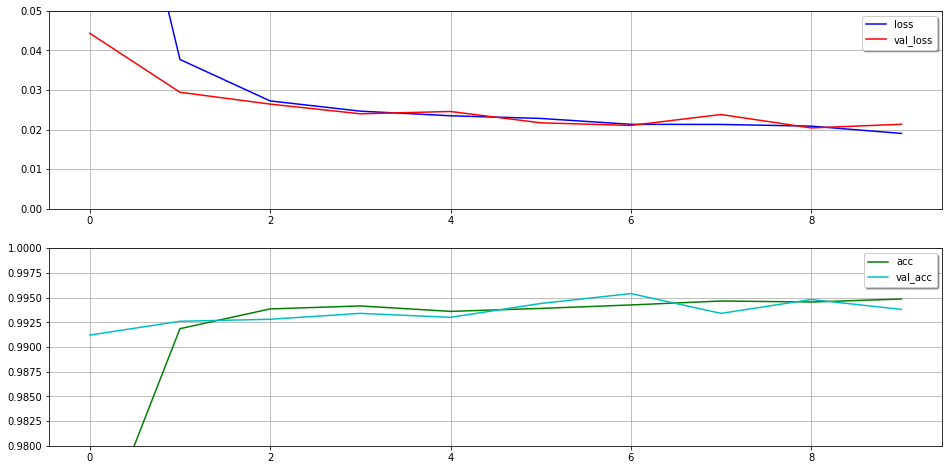

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_loss(Model):
    
    fig, ax = plt.subplots(2,1,figsize=(16, 8))
    his_model = Model.history
    history = his_model.history

    ax[0].plot(history['loss'], color='b', label="loss")
    ax[0].plot(history['val_loss'], color='r', label="val_loss",axes =ax[0])
    ax[0].set_ylim(0, 0.05)
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid(True)

    
    ax[1].plot(history['acc'], color='g', label="acc")
    ax[1].plot(history['val_acc'], color='c',label="val_acc")
    ax[1].set_ylim(0.98, 1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid(True)

X_train = train
X_test = test
y_train = train_generator.classes
X_train, y_train = shuffle(X_train, y_train)

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

show_loss(model)
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")


gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", (299, 299), shuffle=False,
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)